In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import math

## Exercise 11.1: PCA on MNIST

In the lectures the principal component analysis (PCA) was introduced as a
method for dimensionality reduction and feature extraction, i.e., to condense
data by mapping it to a lower dimensional space of the most important features.

Let
\begin{equation*}
  \mathbf{X} = \begin{bmatrix} \mathbf{x}_1^\intercal \\ \vdots \\
    \mathbf{x}_N^\intercal \end{bmatrix} \in \mathbb{R}^{N \times D}
\end{equation*}
be a matrix of $N$ data samples $\mathbf{x}_n \in \mathbb{R}^D$, which are
centered around zero.
We consider a PCA with $M < D$ components.

To project the data points $\mathbf{x}_n$ to the $M$-dimensional space that is
defined by the $M$ principal components of $\mathbf{X}$, the so-called principal
subspace of $\mathbf{X}$, we can use the singular value decomposition of
$\mathbf{X}$. Let $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\intercal$ be the
singular value decomposition of the data matrix $\mathbf{X}$ with the singular
values sorted in descending order.

Then the projection $\mathbf{z}_n$ of
data point $\mathbf{x}_n$ to the principal subspace of $\mathbf{X}$ is given by
\begin{equation}
  \mathbf{z}_n^\intercal = \mathbf{x}_n^\intercal \begin{bmatrix} \mathbf{v}_1 & \cdots & \mathbf{v}_M \end{bmatrix},
\end{equation}
where $\mathbf{v}_i$ is the $i$th column of matrix $\mathbf{V}$. The vector
$\mathbf{z}_n$ can be seen as an encoding of the data point
$\mathbf{x}_n$ in a lower dimensional space that is constructed by the directions
for which the data shows the largest variations.

- **NOTE:** The
  singular value decomposition of a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$
  is defined as a factorization of the form $\mathbf{X} = \mathbf{U} \mathbf{\Sigma}
  \mathbf{V}^\intercal$ where $\mathbf{U} \in \mathbb{R}^{N \times N}$ and
  $\mathbf{V} \in \mathbb{R}^{D \times D}$ are orthogonal matrices and
  $\mathbf{\Sigma} \in \mathbb{R}^{N \times D}$ is a rectangular diagonal matrix with
  non-negative numbers on the diagonal. The diagonal entries of $\mathbf{\Sigma}$ are
  the so-called singular values of $\mathbf{X}$. A common convention is to sort
  the singular values in descending order, in which case the diagonal matrix $\mathbf{\Sigma}$ is uniquely determined by $\mathbf{X}$.

In this exercise, we perform and analyse PCA of the MNIST image data set with $k = 2$ principal components.

In [ ]:
# We use torch and torchvision for automatically downloading the MNIST dataset
import torch
import torchvision
import torchvision.transforms as transforms

# download MNIST datasets and flatten images to vectors of length 784
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.view(-1))])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all training and test images and labels into PyTorch tensors
train_images, train_labels = extract(trainset)
test_images, test_labels = extract(testset)

# It is possible to do the exercise both using torch or numpy.
# In the second case, you can just convert the matrices to numpy using:
# train_images = train_images.numpy()
# train_labels = train_labels.numpy()
# test_images = test_images.numpy()
# test_labels = test_labels.numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Let $\mathbf{X} \in [0,1]^{N \times 784}$ be a matrix of the MNIST training data set with $N = 60000$, where each row represents a training image. Moreover, let $\mathbf{X} - \overline{\mathbf{x}}^\intercal = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\intercal$ be the singular value decomposition of the MNIST training data after them mean has been removed, where $\overline{\mathbf{x}} = \frac{1}{N} \sum_{i=1}^N \mathbf{x}_i$.

We compute the singular value decomposition $\mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^\intercal$ with the function [`torch.svd`](https://pytorch.org/docs/stable/torch.html#torch.svd).

In [ ]:
# center training images
train_mean = train_images.mean(axis=0)
train_images_centered = train_images - train_mean

U, S, V = torch.svd(train_images_centered)

### Item (a)

Let `train_encoding` $\in \mathbb{R}^{60000 \times 2}$ and `test_encoding` $\in \mathbb{R}^{10000 \times 2}$ be the two-dimensional principal subspace of the MNIST training images. Compute the two encodings of the images in the MNIST training and the test data set.  Do it with the help of $\mathbf{U}$, $\boldsymbol{\Sigma}$, and $\mathbf{V}$.

*Hints*: Rememeber that the presence of the center $\overline{\textbf{x}}$ needs to be accounted for.


In [ ]:
train_encoding = torch.matmul(train_images_centered, V[:,0:2])
print('Train_encoding: ', train_encoding.shape)

test_encoding = torch.matmul(test_images - train_mean, V[:,0:2])
print('Test_encoding: ', test_encoding.shape)

Train_encoding:  torch.Size([60000, 2])
Test_encoding:  torch.Size([10000, 2])


Generate 2D scatter plots showing of the datapoints you computed in the last item. The function `plot_encoding` bellow can be used to generate a plot of the latent space.

In [ ]:
def plot_encoding(train_data, test_data):
    # create two plots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # plot data
    titles = ["training data", "test data"]
    for (data, title, ax) in zip([train_data, test_data], titles, axes.flat):
        encodings, labels = data
        scatter = ax.scatter(encodings[:, 0], encodings[:, 1],
                             c=labels, cmap=plt.cm.tab10, vmin=-0.5,
                             vmax=9.5, alpha=0.7)
        ax.set_xlabel("$z_1$")
        ax.set_ylabel("$z_2$")
        ax.set_title(title)

    # add colorbar
    cb = fig.colorbar(scatter, ticks=np.arange(0, 10), ax=axes.ravel().tolist())
    cb.ax.set_title("digit")
    
    return fig

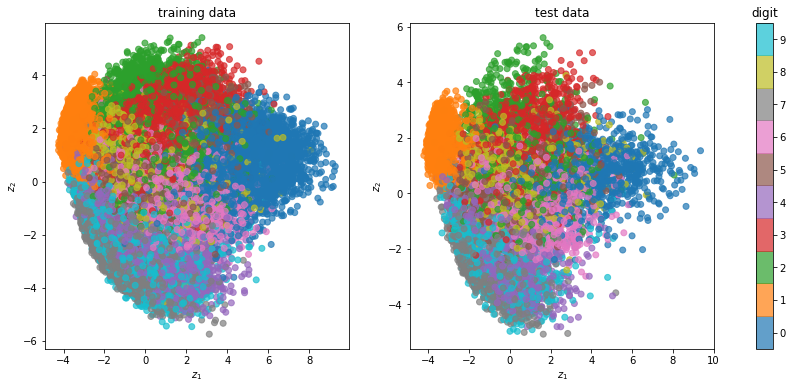

In [ ]:
plot_encoding((train_encoding, train_labels), (test_encoding, test_labels))
plt.show()

### Item (b)

With the help of the matrices $\mathbf{U}$, $\boldsymbol{\Sigma}$, and $\mathbf{V}$ computed in the last item. Map the `test_encoding` from the enconding space back to the space of image obtaining: `test_reconstruction` $\in \mathbb{R}^{10000 \times 784}$ which will consist of the images in the MNIST test data set obtained considering only the two principal components.

In [ ]:
test_reconstruction = torch.matmul(test_encoding, np.transpose(V[:,0:2])) + train_mean

Plot some test images and their reconstructed counterparts. You can use the function `plot_reconstruction` bellow do the plotting. Which digits can be reconstructed and decoded quite well, and which ones seem to be more challenging?

In [ ]:
# plot at most 8 random reconstructions
def plot_reconstruction(originals, reconstructions, labels, nrow=2):
    # indices of displayed samples
    n = originals.size(0)
    indices = range(n) if n <= 8 else np.random.choice(n, size=8, replace=False)

    # compute number of rows and columns of grid
    num_samples = len(indices)
    num_cols = min(nrow, num_samples)
    num_rows = int(math.ceil(float(num_samples) / nrow))

    fig = plt.figure(figsize=(5 * num_cols, 2.5 * num_rows))
    for (i, idx) in enumerate(indices):
        # extract original, reconstruction, and label
        original = originals[idx]
        reconstruction = reconstructions[idx]
        label = labels[idx]

        # configure subplot
        plt.subplot(num_rows, num_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title(f"Label: {label.item()}", fontweight='bold')

        # plot original and reconstructed image
        # design a grid, similar to torchvision.utils.make_grid
        grid = torch.ones(1, 1, 32, 62)
        grid.narrow(2, 2, 28).narrow(3, 2, 28).copy_(
            original.view(-1, 1, 28, 28))
        grid.narrow(2, 2, 28).narrow(3, 32, 28).copy_(
            reconstruction.view(-1, 1, 28, 28))
        plt.imshow(grid.squeeze().cpu().numpy(),
                   vmin=0.0, vmax=1.0, cmap='gray_r')

    return fig

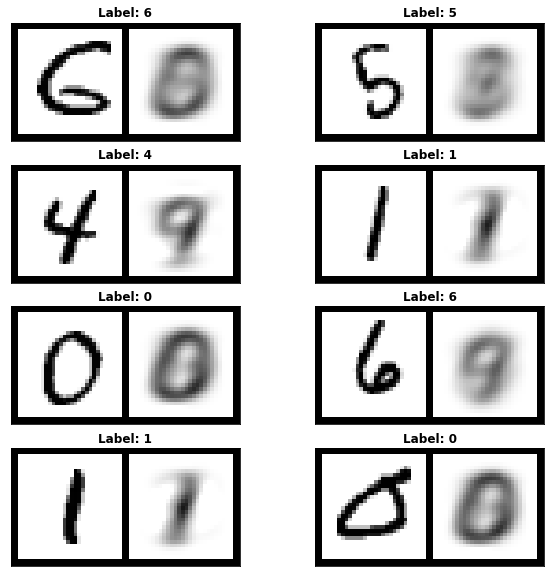

In [ ]:
plot_reconstruction(test_images, test_reconstruction, test_labels)
plt.show()

### Item (c)

The comparison of the original images and their reconstructions provides us with some intuition for how much information is lost by the compression of the images to the two-dimensional latent space. As a less subjective measure we calculate the average squared reconstruction error. An advantage of an objective measure such as the average squared reconstruction error is that it enables us to compare the PCA with other models for dimensionality reduction.
\begin{equation*}
\mathrm{sqerr} := \frac{1}{10000} \sum_{i=1}^{10000} \|\mathbf{x}_i - \tilde{\mathbf{x}}_i\|^2_2
\end{equation*}
of the images $\mathbf{x}_i \in {[0,1]}^{784}$ and their reconstruction $\tilde{\mathbf{x}}_i \in \mathbb{R}^{784}$ ($i = 1,\ldots, 10000$) in the MNIST test data set. 

What average squared reconstruction error do you get with PCA?

In [ ]:
sqerr = torch.sum((test_images - test_reconstruction)**2)/len(test_images)
print(f'Average squared reconstruction error: {sqerr}')

Average squared reconstruction error: 43.64488220214844


### Item (d)

For each digit from 1 to 9, compute the mean of the data training points in the encoding space.

In [ ]:
train_mean_encodings = torch.zeros(10,2)
repetitions = torch.zeros(10)
for (encoding, label) in zip(train_encoding, train_labels):
  repetitions[label] += 1
  train_mean_encodings[label,:] += (encoding-storage[label,])/(repetitions[label])

Generate the images corresponding to each of the means obtained in the encode space. Use the SVD matrix to convert the encoding space back to the image space. Use the the function `plot_images` bellow to generate a plot of that image.

In [ ]:
def plot_images(images, labels=None, nrow=5):
    # compute number of columns of grid
    num_samples = images.size(0)
    num_cols = min(nrow, num_samples)
    num_rows = int(math.ceil(float(num_samples) / nrow))

    fig = plt.figure(figsize=(2 * num_cols, 2 * num_rows))
    for i in range(num_samples):
        # extract image and labels if provided
        image = images[i]
        label = None if labels is None else labels[i]

        # configure subplot
        plt.subplot(num_rows, num_cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if label is not None:
            plt.title(f"Label: {label.item()}", fontweight='bold')

        # plot image
        plt.imshow(image.view(28, 28).cpu().numpy(),
                   vmin=0.0, vmax=1.0, cmap='gray_r')
        
    return fig

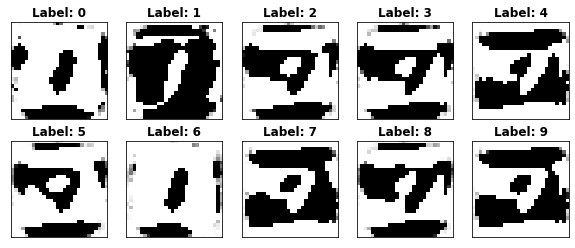

In [ ]:
# compute mean images
train_mean_images = train_mean + train_mean_encodings.mm(V[:, :2].t())

plot_images(train_mean_images, torch.arange(10))
plt.show()

## Exercise 11.2 - Derivations for probabilistic PCA


In constrast to (regular) PCA, the so-called probabilistic PCA (PPCA) allows a probabilistic
interpretation of the principal components. The probabilistic formulation
of PCA also allows us to extend the method and alter its underlying assumptions
quite easily, as we will learn during the course of this laboratory.


As before, let $\mathbf{x} \in \mathbb{R}^D$ represent a data sample that we
want to decode from a lower dimensional representation
$\mathbf{z} \in \mathbb{R}^M$ with $M < D$. The PPCA model assumes that
$\mathbf{z}$ is standard normally distributed and $\mathbf{x}$
can be decoded by a noisy linear transformation of $\mathbf{z}$.
Mathematically, the model is given by
\begin{align*}
  p(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mathbf{W}\mathbf{z} + \boldsymbol{\mu}, \sigma^2 \mathbf{I}_D\right), \\
  p(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_M),
\end{align*}
with parameters $\mathbf{W} \in \mathbb{R}^{D \times M}$,
$\boldsymbol{\mu} \in \mathbb{R}^D$, and $\sigma^2 > 0$.
[Michael E. Tipping and Christopher M. Bishop show in "Probabilistic Principal Component Analysis"](https://www.jstor.org/stable/2680726)
that for $\sigma^2 \to 0$
the model recovers the standard PCA (but the components of $\mathbf{z}$ might
be permuted).

We assume that the data $\mathbf{x}_1, \ldots, \mathbf{x}_N$ is identically
and independently distributed according to the PPCA model. In a maximum
likelihood setting, one determines the parameters $\mathbf{W}$, $\boldsymbol{\mu}$,
and $\sigma^2$ that maximize the likelihood
\begin{equation*}
  p(\mathbf{x}_1, \ldots, \mathbf{x}_N ; \mathbf{W}, \boldsymbol{\mu}, \sigma^2)
  = \prod_{n=1}^N p(\mathbf{x}_n; \mathbf{W}, \boldsymbol{\mu}, \sigma^2),
\end{equation*}
or equivalently the log-likelihood
\begin{equation*}
  \log p(\mathbf{x}_1, \ldots, \mathbf{x}_N; \mathbf{W}, \boldsymbol{\mu}, \sigma^2)
  = \sum_{n=1}^N \log p(\mathbf{x}_n; \mathbf{W}, \boldsymbol{\mu}, \sigma^2).
\end{equation*}

### Item (a) 

*(Pen and paper exercise)*

Show that for the model of the probabilistic PCA
  \begin{equation*}
    p(\mathbf{x}) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \mathbf{C}),
  \end{equation*}
  where $\mathbf{C} = \mathbf{W}\mathbf{W}^\intercal + \sigma^2 \mathbf{I}_D$.



### Item (b)
*(Pen and paper exercise)*

Show that the distribution of the latent variable $\mathbf{z}$ conditioned on
  $\mathbf{x}$ is Gaussian as well and given by
  \begin{equation*}
    p(\mathbf{z} \,|\, \mathbf{x}) = \mathcal{N}\left(\mathbf{z}; \mathbf{M}^{-1} \mathbf{W}^\intercal (\mathbf{x} - \boldsymbol{\mu}), \sigma^2 \mathbf{M}^{-1} \right),
  \end{equation*}
  where $\mathbf{M} = \mathbf{W}^\intercal \mathbf{W} + \sigma^2 \mathbf{I}_M$.




## Exercise 11.3 - Gaussian Mixture Models


Consider the dataset generated bellow. It was generated using a gaussian mixture. That is the dataset is generated as follows:

- We sample a variable `pp` from a bernouly distribution with probability `pi = 0.7`.
- When the result is equal to one (`pp == 1`) we sample from the normal:
$$\mathcal{N}\left(\mu_1 = \begin{bmatrix} 1 \\ 2\end{bmatrix}, \Sigma_1 = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}\right)$$

- When the result is equal to one (`pp == 0`) we sample from the normal:
$$\mathcal{N}\left(\mu_2 = \begin{bmatrix} 5 \\ 7\end{bmatrix}, \Sigma_2 = \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}\right)$$


In this exercise, you will use an expectation maximization algorithm to estimate the parameters of gaussian mixture model to fit this dataset. Using what you implemented, you will apply this model to the two dimensional encondings from the exercise 11.1.

In [ ]:
from scipy.stats import multivariate_normal, uniform, bernoulli

def plot_2dnormal(ax, vnormal, color='red'):
  # Plot center
  plt.plot(vnormal.mean[0], vnormal.mean[1], '*', ms=5, color=color)
  # Get countour grid
  x, y = np.mgrid[-3:3:.01, -3:3:.01]
  # rescale x, y
  x = vnormal.cov[0,0] * x +  vnormal.mean[0]
  y = vnormal.cov[1,1] * y +  vnormal.mean[1]
  # Plot countour
  pos = np.dstack((x, y)) 
  ax.contour(x, y, vnormal.pdf(pos), colors=color, levels=3)

# First normal distribution
mu1 = [1, 2]
cov1 = [[2, 0], [0, 1]]
n1 = multivariate_normal(mean=mu1, cov= cov1)
# Parameters of the second normal distribution
mu2 = [5, 7]
cov2 = [[2, 1], [1, 2]]
n2 = multivariate_normal(mean=mu2, cov=cov2)
# Probability of belonging to each
pi = 0.7
pp = bernoulli(p=pi)
odds = [pi, 1 - pi]
# Create a list with all the normals
vnormals = [n1, n2]

# Sample N=300 samples from each
N = 300
v1 = n1.rvs(N)
v2 = n2.rvs(N)
p = pp.rvs(N)

gmm_data = np.where(p[:, None] == 1, v1, v2)

fig, ax = plt.subplots()
ax.scatter(gmm_data[:,0], gmm_data[:,1])
plot_2dnormal(ax, n1, color='red')
plot_2dnormal(ax, n2, color='blue')
plt.show()

### Item (a)

Implement a function `e_step`  that receives as input:
-  the `gmm_data`: which is an `300 x 2` np array generated above;
-  the `odds`: which is a list containing as elements the `pi` and `1 - pi`; and
- the `vnormals`: a list  `[n1, n2]` of variable generated using: (`multivariate_normal`)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html]. See `vnormals` above.

and outputs a vector of dimension `300 x 2 ` containing the probability of `pp = 1` for each of the points. This is equivalent, in each row:
$$\left(\frac{\pi_1\mathcal{N}\left(x; \mu_1 , \Sigma_1\right)}{\sum_i \pi_i\mathcal{N}\left(x; \mu_i , \Sigma_i\right)},  \frac{\pi_2\mathcal{N}\left(x; \mu_2 , \Sigma_2\right)}{\sum_i \pi_i\mathcal{N}\left(x; \mu_i , \Sigma_i\right)}\right) $$

This computation corresponds to expectation step in the expectation maximization algorithm.

In [ ]:
def e_step(gmm_data, odds, vnormals):
    return ## TODO

Bellow the function uses the values produced by such function to computed to decide whether a point from the data is associated with each center.

In [ ]:
# appy the function to the dataset
ws = e_step(gmm_data, odds, vnormals)

# Use it to decide to which normal it belongs to
fig, ax = plt.subplots()
plot_2dnormal(ax, n1, color='black')
plot_2dnormal(ax, n2, color='black')
belong_to = ws.argmax(axis=0)
ax.scatter(gmm_data[belong_to==0,0], gmm_data[belong_to==0,1], color='red')
ax.scatter(gmm_data[belong_to==1,0], gmm_data[belong_to==1,1], color='blue')
plt.show()

### Item (b)

Implement a function `m_step`  that receives as input:
-  the `gmm_data`: which is an `300 x 2` np array generated above;
-  the `ws`: which is an `300 x 2` np array giving in the first row the probability of a point belonging to the first normal in the mixture. And, in the second row, the probability of a point belonging to the first normal in the mixture. I.e. similar to the output of the function `e_step` implemented above.

It outputs the parameters of the mixture:
-  the `odds`: which is a list containing as elements the `pi` and `1 - pi`; and
- the `vnormals`: a list  `[n1, n2]` of variable generated using: (`multivariate_normal`)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html]. See `vnormals` above.

This can be done using Eq. 10.16 from http://smlbook.org/.

In [ ]:
def m_step(gmm_data, ws):
    return ### TODO

You can use the values computed in the last few items as a sanity check:



In [ ]:
odds, vnormals = m_step(gmm_data, ws)

print('odds:')
print(odds)
print('')
for i, rv in enumerate(vnormals):
  print('Normal {}'.format(i+1))
  print('- mean:')
  print(rv.mean)

  print('- cov:')
  print(rv.cov )
  print('')

If everything went right, you should obtain values close to the ones used to generate the dataset:

- `odds` $\approx$ [0.7 0.3]
- The first normal: $$\mu_1 = \begin{bmatrix} 1 \\ 2\end{bmatrix}, \Sigma_1 = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix}$$
-  The first normal: $$\mu_2 = \begin{bmatrix} 5 \\ 7\end{bmatrix}, \Sigma_2 = \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}$$


### Item (c)
Use the code bellow to plot 3 iterations of the Expectation-Maximization algorithm in the dataset generated above.

In [ ]:
# Initialization
mu1 =  [0, 0]
cov1 = [[1, 0], [0, 1]]
n1_estimated = multivariate_normal(mean=[0, 0], cov= cov1)
# Parameters of the second normal distribution
mu2 = [10, 10]
cov2 = [[1, 0], [0, 1]]
n2_estimated  = multivariate_normal(mean=mu2, cov=cov2)
vnormals_estimated = [n1_estimated, n2_estimated]
# Probability of belonging to each
odds_estimated = [0.5, 0.5]


for i in range(3):
  fig, ax = plt.subplots()
  ws = e_step(gmm_data, odds_estimated, vnormals_estimated)
  belong_to = ws.argmax(axis=0)
  ax.scatter(gmm_data[:, 0], gmm_data[:, 1], c=belong_to)
  for j in range(ws.shape[0]):
    plot_2dnormal(ax, vnormals_estimated[j], color='black')

  odds_estimated, vnormals_estimated = m_step(gmm_data, ws)
  plt.show()

### Item (d)

Adapt the code above and apply the method to MNIST 2 dimensional encoding you generated in Exercise 11.1. You can choose how many centers you want to use and what initialization parameters.